## AHRS algorithm comparison

Author:　Ｈsiu-Wen Chang
Date: 2022.06.07

The purpose of this notebook is to describe various attitude estimator for low-cost MEMS sensors also know as AHRS. A list of various algorithms in the following table will be covered and its performance will be evaluated by real field test.

| Algorithm     | Gyroscope | Accelerometer | Magnetometer |
|---------------|:---------:|:-------------:|:------------:|
| AQUA          | YES       | YES           | Optional     |
| Complementary | YES       | YES           | Optional     |
| Davenport's   | NO        | YES           | YES          |
| EKF           | YES       | YES           | YES          |
| FAMC          | NO        | YES           | YES          |
| FLAE          | NO        | YES           | YES          |
| Fourati       | YES       | YES           | YES          |
| FQA           | NO        | YES           | Optional     |
| Integration   | YES       | NO            | NO           |
| Madgwick      | YES       | YES           | Optional     |
| Mahony        | YES       | YES           | Optional     |
| OLEQ          | NO        | YES           | YES          |
| QUEST         | NO        | YES           | YES          |
| ROLEQ         | YES       | YES           | YES          |
| SAAM          | NO        | YES           | YES          |
| Tilt          | NO        | YES           | Optional     |
| TRIAD         | NO        | YES           | YES          |

## 1. Basic conversion between euler angles, direction cosine matrix and quaternion

### 1.1 Quaternion
A quaternion consiste four elements $$q=[q_w,q_x,q_y,q_z]^T$$ where the corresponding rotation $\alpha$ around an axis of rotation is by the following $$ q_w=cos(\alpha/2)\\q_x=sin(\alpha/2)cos(\beta_x)\\q_y=sin(\alpha/2)cos(\beta_y)\\q_z=sin(\alpha/2)cos(\beta_z)$$ where $cos(\beta_x),cos(\beta_y), cos(\beta_z)$ are the direction cosines of the angles between the three coordinate axes and the axis of rotation. Some literature denots these in $e_x, e_y, e_z$
### 1.2 Quaternion to DCM
inhomogeneous expression of the conversion is applied in ahrs python source code: 
$$ R=\begin{bmatrix}1-2(q_{y}^2+q_{z}^2) & 2(q_{x}q_{y}-q_{x}q_{z}) & 2(q_{x}q_{z}+q_{x}q_{z}) \\\\ 2(q_{x}q_{y}+q_{w}q_{z}) & 1-2(q_{x}^2+q_{z}^2) & 2(q_{y}q_{z} - q_{w}q_{x}) \\\\ 2(q_{x}q_{z} - q_{w}q_{y}) & 2(q_{w}q_{x} + q_{y}q_{z}) & 1 - 2(q_{x}^2 + q_{y}^2)\end{bmatrix}$$
This is equivalent to the homogeneous expression: 
$$ R=\begin{bmatrix}q_{w}^2+q_{x}^2-q_{y}^2-q_{z}^2 & 2(q_{x}q_{y}-q_{x}q_{z}) & 2(q_{x}q_{z}+q_{x}q_{z}) \\\\ 2(q_{x}q_{y}+q_{w}q_{z}) & q_{w}^2-q_{x}^2+q_{y}^2-q_{z}^2 & 2(q_{y}q_{z} - q_{w}q_{x}) \\\\ 2(q_{x}q_{z} - q_{w}q_{y}) & 2(q_{w}q_{x} + q_{y}q_{z}) & q_{w}^2-q_{x}^2-q_{y}^2+q_{z}^2)\end{bmatrix}$$

### 1.3 Euler to DCM
Given $(\phi, \theta, \psi)$ angles to rotate (X,Y,Z) to (x,y,z) can be achieved by:
$$\begin{bmatrix}x\\y\\z\\ \end{bmatrix}=R_{z}(\psi )R_{y}(\theta )R_{x}(\phi )\begin{bmatrix}X\\Y\\Z\end{bmatrix} \\
=\begin{bmatrix}\cos(\psi) & -\sin(\psi)& 0 \\ \sin(\psi) &\cos(\psi) &0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}\cos(\theta) & 0 & \sin(\theta) \\ 0 & 1 & 0 \\ \sin(\theta) & 0 & \cos(\theta) \\ \end{bmatrix}
\begin{bmatrix}1 & 0 &0\\0 & \cos \phi &-\sin \phi \\0 & \sin \phi & \cos \phi \\\end{bmatrix}
\begin{bmatrix}X\\Y\\Z\\\end{bmatrix}\\
=\begin{bmatrix}\cos \theta \cos \psi &-\cos \phi \sin \psi +\sin \phi \sin \theta \cos \psi &\sin \phi \sin \psi +\cos \phi \sin \theta \cos \psi \\\cos \theta \sin \psi &\cos \phi \cos \psi +\sin \phi \sin \theta \sin \psi &-\sin \phi \cos \psi +\cos \phi \sin \theta \sin \psi \\-\sin \theta &\sin \phi \cos \theta &\cos \phi \cos \theta \end{bmatrix}
\begin{bmatrix}X\\Y\\Z\end{bmatrix}$$
Be aware that there are several different rotation sequecne to reach DCM. It is possible to find 'xyz', 'zyx', 'zyz', etc. in MatLab.

### Quaternion to Euler
$$\begin{bmatrix}\phi \\ \theta \\ \psi \end{bmatrix}=\begin{bmatrix} atan2(2(q_{w}q_{x}+q_{y}q_{z}),1-2(q_{x}^2+q_{y}^2) \\ asin(2(q_{w}q_{y}-q_{z}q_{x}) \\ atan2(2(q_{w}q_{z}+q_{x}q_{y},1-2(q_{y}^2+q_{z}^2)) \end{bmatrix}$$

PAY ATTENTION: AHRS package provides q2euler and q2rpy. The above equation is corresponding to q2rpy function. For q2euler fuction, the formula is derived from unit quaternion and given as:
$$\begin{bmatrix}\phi \\ \theta \\ \psi \end{bmatrix}=
\begin{bmatrix} 
atan2(2(q_{y}q_{z} - q_{w}q_{x}), - 1 + 2(q_{w}^2+q_{z}^2) \\ 
-arctan(2(q_{x}q_{z} + q_{w}q_{y})/\sqrt{(1-(2(q_{x}q_{z} + q_{w}q_{y}))^2}) \\
atan2(2(q_{x}q_{y} - q_{w}*q_{z}),- 1 + 2(q_{w}^2+q_{x}^2)) 
\end{bmatrix}$$


In [1]:
%matplotlib notebook 

import numpy as np
import glob
import os
import matplotlib.pyplot as plt
# Please pay attention to your path naming system
print(os.getcwd())

/mnt/c/Users/Kelly/Desktop/XW_NCKU project/python/ahrs_robust


Dataset collected on April, 4, 2022

Activity: jogging on treadmill from speed 

device: OSMIMU, MIMU22BL

PPT: 20220415_multiIMU.pptx

format: PKT_No. 	    TimeStamp 	    ax(m/s^2) 	    ay(m/s^2) 	    az(m/s^2) 	    gx(rad/s) 	    gy(rad/s) 	    gz(rad/s) 	       mx(μT) 	       my(μT) 	       mz(μT) 

Allocation of IMU on board
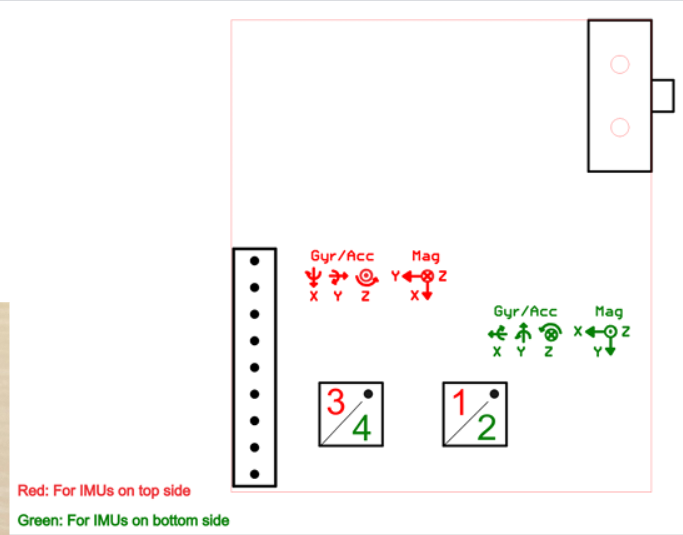
Location on human wraist 
<img src="figures/device_allocation_jogging_04122022.png" width=200 height=200 />



In [2]:
file_root = '../../data/20220414_NCKU_GYM/Data'
files_sequence = os.listdir(file_root)
#P1211: right wrist, 4 imu array
#P1213: left wrist,  1 imu array
#P1214: left wrist, 4 imu array
print(files_sequence)


['P1211', 'P1213', 'P1214', 'ReadME.md.docx']


In [3]:
# practice to get all txt files
counter = 0
for sequence in files_sequence:
    if os.path.isdir(os.path.join(file_root,sequence)):
        files_path = glob.glob(os.path.join(file_root,sequence,'*.txt'))
        counter += len(files_path)
        print(files_path)
print('Total imu files:', counter)


['../../data/20220414_NCKU_GYM/Data/P1211/62.5Hz_20220414_160845.txt', '../../data/20220414_NCKU_GYM/Data/P1211/62.5Hz_20220414_162003.txt', '../../data/20220414_NCKU_GYM/Data/P1211/62.5Hz_20220414_162731.txt', '../../data/20220414_NCKU_GYM/Data/P1211/62.5Hz_20220414_163305.txt', '../../data/20220414_NCKU_GYM/Data/P1211/62.5Hz_20220414_165645.txt']
['../../data/20220414_NCKU_GYM/Data/P1213/62.5Hz_20220414_160844.txt', '../../data/20220414_NCKU_GYM/Data/P1213/62.5Hz_20220414_162003.txt', '../../data/20220414_NCKU_GYM/Data/P1213/62.5Hz_20220414_162732.txt', '../../data/20220414_NCKU_GYM/Data/P1213/62.5Hz_20220414_163306.txt', '../../data/20220414_NCKU_GYM/Data/P1213/62.5Hz_20220414_165642.txt']
['../../data/20220414_NCKU_GYM/Data/P1214/62.5Hz_20220414_160833.txt', '../../data/20220414_NCKU_GYM/Data/P1214/62.5Hz_20220414_161951.txt', '../../data/20220414_NCKU_GYM/Data/P1214/62.5Hz_20220414_162720.txt', '../../data/20220414_NCKU_GYM/Data/P1214/62.5Hz_20220414_163254.txt', '../../data/20220

In [4]:
# path: C:\Users\Kelly\Desktop\XW_NCKU project\data\20220414_NCKU_GYM\Data\P1211
seq = files_path = glob.glob(os.path.join(file_root,files_sequence[0],'*.txt'))
imu = np.genfromtxt(seq[0], skip_header=3)

In [5]:
print(imu.shape)

(16415, 11)


In [6]:
imu[0]

array([ 1.0000000e+00,  1.6000000e-02,  2.1850600e-01, -6.4992630e+00,
        6.7524370e+00,  3.7392400e-01,  5.3228000e-02, -1.6870100e-01,
        3.7350563e+01, -2.9100565e+01,  3.6450565e+01])

In [30]:
def draw_raw_data(imu):
    fig, axs = plt.subplots(3, 1, sharex=True)
    axs[0].set(ylabel='accel (m/s/s)', title='MIMU reading')
    axs[1].set(ylabel='gyro (rad/s)')
    axs[2].set(xlabel='$t$ (s)', ylabel='mag (microtesla)')

    for i in range(3):
        axs[i].plot(imu[:,1], imu[:,2+i*3], label='x')
        axs[i].plot(imu[:,1], imu[:,3+i*3], label='y')
        axs[i].plot(imu[:,1], imu[:,4+i*3], label='z')
        axs[i].grid()
        axs[i].legend()

    plt.show()
    
def draw_attitude(ahrs):
    fig, axs = plt.subplots(3,1,sharex=True)
    axs[0].set(ylabel='roll (deg)',title='Attitude')
    axs[1].set(ylabel='pitch (deg)')
    axs[2].set(ylabel='yaw (deg)')
    #axs[0].plot(ahrs[:,0], ahrs[:,1]/np.pi*180)
    #axs[1].plot(ahrs[:,0], ahrs[:,2]/np.pi*180)
    #axs[2].plot(ahrs[:,0], ahrs[:,3]/np.pi*180)
    #index_mask = [s for s in range((ahrs.shape[1]-1)//3)]
    for i in range((ahrs.shape[1]-1)//3):
        axs[0].plot(ahrs[:,0], ahrs[:,1+i*3]/np.pi*180, label=f"roll_{i}")
        axs[1].plot(ahrs[:,0], ahrs[:,2+i*3]/np.pi*180, label=f"pitch_{i}")
        axs[2].plot(ahrs[:,0], ahrs[:,3+i*3]/np.pi*180, label=f"yaw_{i}")
    
    for i in range(3):
        axs[i].grid()
        axs[i].legend()
    
    plt.show()
    

<IPython.core.display.Javascript object>


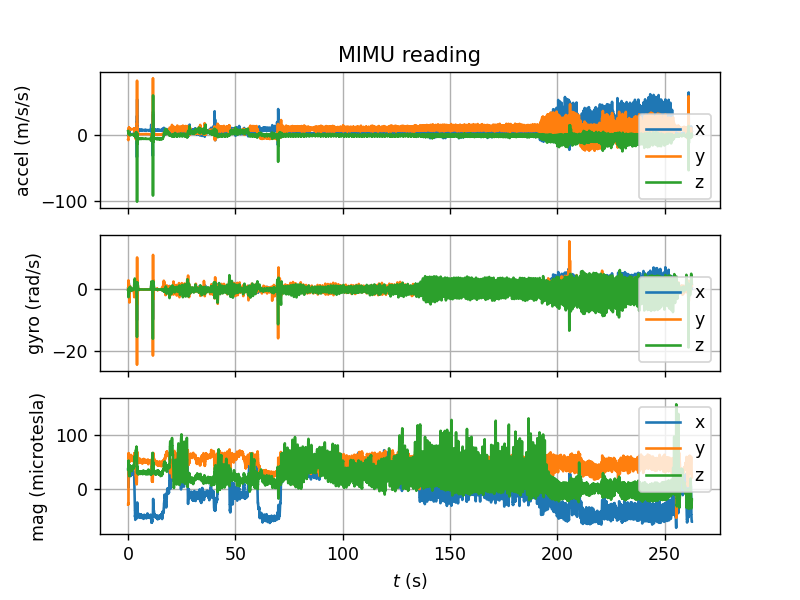

In [10]:
# 3 km/hr: 72.5 s to 135 s
# 6 km/hr: 135 s to 192 s
# 10 km/hr: 192 s to 253.5 s
draw_raw_data(imu)

# AQUA: algebraic quaternion algorithm
Concept: [AQUA](https://res.mdpi.com/sensors/sensors-15-19302/article_deploy/sensors-15-19302.pdf) estimate the attitude with the algebraic solution of system from inertial/magnetic observation. It use accelerometer to compute the tilt quaternion (levelling) and the heading quaternion (north direction) by magnetometer. The key advantage of AQUA is the independence of two sub-parts of tilt quaterinion and heading quaternion. By sepearating the computation, it avoids the impact of magnetic disturbances on the roll and pitch estimation. 

In [11]:
time_start = 72.5
time_end = 253.5
imu2 = imu[(imu[:,1]>time_start) & (imu[:,1]<time_end),:]


<IPython.core.display.Javascript object>


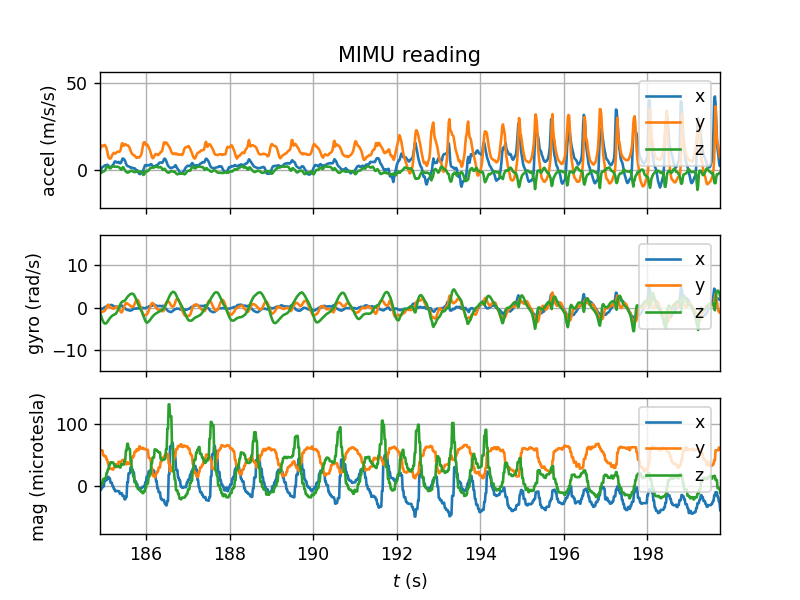

In [21]:
draw_raw_data(imu2)

<IPython.core.display.Javascript object>


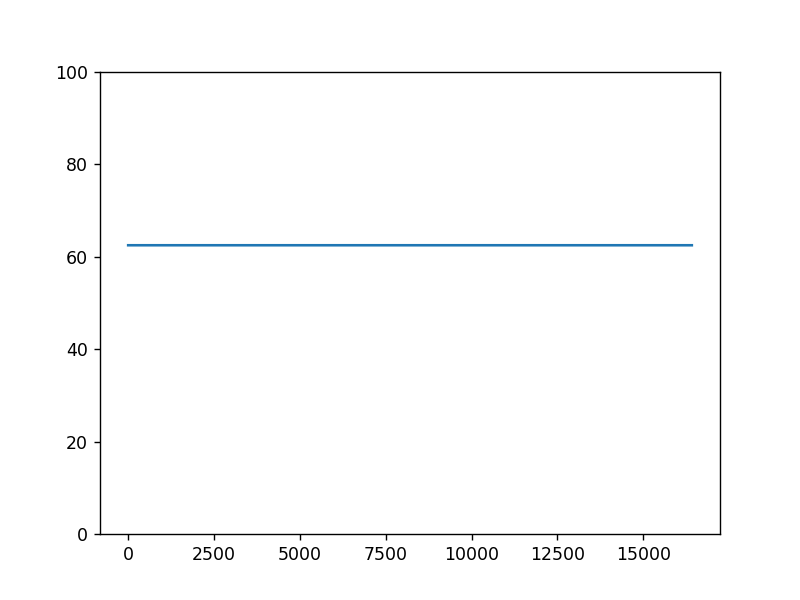

(0.0, 100.0)

In [13]:
# Check time tag values
plt.figure
#plt.plot(np.diff(imu[:,1]))
#plt.ylim(0,0.1)
plt.plot(1/np.diff(imu[:,1]))
plt.ylim(0,100)

Now lets see the performance of Magwick AHRS algorithm with and without magnetomter

In [14]:
import ahrs

In [33]:
# to get intial q_0, run Madwick with mag first to in order to find yaw_0
attitude_magwick_marg = ahrs.filters.Madgwick(acc=imu2[:,2:5], gyr=imu2[:,5:8],mag=imu2[:,8:11],frequency=62)
#print('yaw_0 estimated by MARG:{}')
attitude = ahrs.filters.Madgwick(acc=imu2[:,2:5], gyr=imu2[:,5:8],q0 = attitude_marg.Q[0],frequency=62)


In AHRS package, you can find two ways to transform quaternion into three rotation angles: (1) q2euler $$ $$ (2) q2rpy: $$    \begin{bmatrix}\psi \\ \theta \\ \phi \end{bmatrix} = \begin{bmatrix}\arctan2 (2(q_{w}q{x} + q_{y}q{z}), 1.0 - 2(q_{x}^2 + q_{y}^2)) \\ \arctan2(2(q_{w}q_{y} - q_{z}q_{x})) \\ \arctan2(2(q_{w}q_{z} + q_{x}q_{y}), 1.0 - 2(q_{z}^2 + q_{z}^2))\end{bmatrix}$$

In [34]:
euler_angles = np.asarray([ahrs.common.orientation.q2euler(s) for s in attitude.Q]) #this formula is different to wiki
rpy_angles = np.asarray([ahrs.common.orientation.q2rpy(s) for s in attitude.Q])

euler_angles_marg = np.asarray([ahrs.common.orientation.q2euler(s) for s in attitude_marg.Q]) #this formula is different to wiki
rpy_angles_marg = np.asarray([ahrs.common.orientation.q2rpy(s) for s in attitude_marg.Q])

In [35]:
orientations = np.hstack((imu2[:,1].reshape(-1,1),euler_angles,euler_angles_marg))
orientations2 = np.hstack((imu2[:,1].reshape(-1,1),rpy_angles, rpy_angles_marg))

<IPython.core.display.Javascript object>


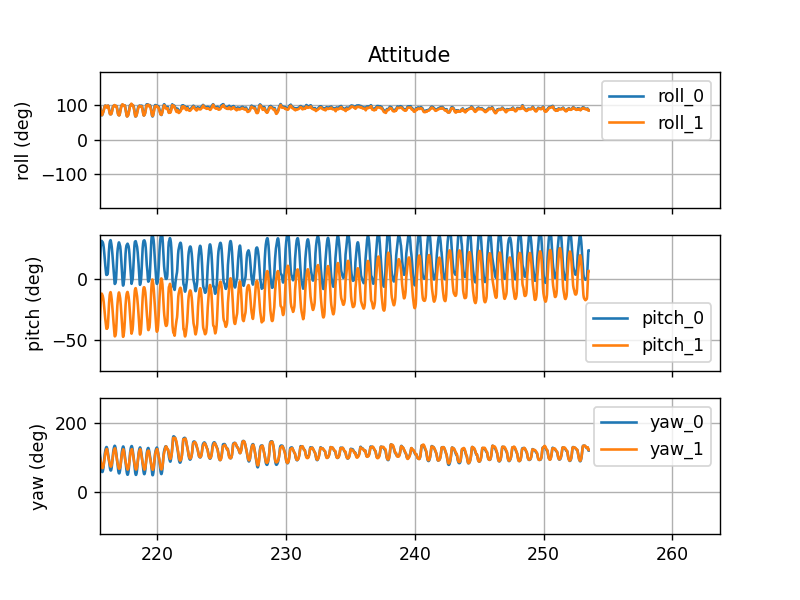

<IPython.core.display.Javascript object>


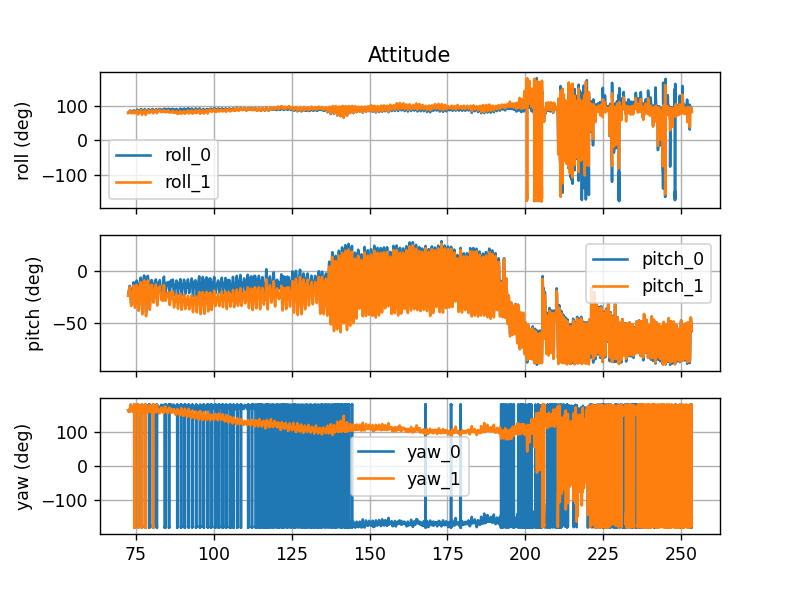

In [36]:
draw_attitude(orientations)
draw_attitude(orientations2)